## 网页爬取+多模态内容识别+RAG构建本地知识库+中文大语言模型

1. 网页爬取和解析，生成本地元数据  [OrcaStudio介绍](http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/README),
2. 分析元数据中的文本和图片，放入 vector store
3. 基于 vector store + qwen 模型的问答功能


## 网页爬取和解析，生成本地元数据

## Data Loading

### Partition PDF tables, text, and images
  
* `LLaVA` Paper: https://arxiv.org/pdf/2304.08485.pdf
* Use [Unstructured](https://unstructured-io.github.io/unstructured/) to partition elements

In [2]:
from typing import Any

from pydantic import BaseModel
from unstructured.partition.pdf import partition_pdf

# Path to save images
path = "/home/huangwei1/Downloads/"

# Get elements
raw_pdf_elements = partition_pdf(
    filename=path + "LLaVA.pdf",
    # Using pdf format to find embedded image blocks
    extract_images_in_pdf=True,
    # Use layout model (YOLOX) to get bounding boxes (for tables) and find titles
    # Titles are any sub-section of the document
    infer_table_structure=True,
    # Post processing to aggregate text once we have the title
    chunking_strategy="by_title",
    # Chunking params to aggregate text blocks
    # Attempt to create a new chunk 3800 chars
    # Attempt to keep chunks > 2000 chars
    # Hard max on chunks
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

This function will be deprecated in a future release and `unstructured` will simply use the DEFAULT_MODEL from `unstructured_inference.model.base` to set default model name
Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSe

In [3]:
# Create a dictionary to store counts of each type
category_counts = {}

for element in raw_pdf_elements:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Unique_categories will have unique elements
# TableChunk if Table > max chars set above
unique_categories = set(category_counts.keys())
category_counts

{"<class 'unstructured.documents.elements.CompositeElement'>": 31,
 "<class 'unstructured.documents.elements.Table'>": 4}

In [4]:
class Element(BaseModel):
    type: str
    text: Any


# Categorize by type
categorized_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        categorized_elements.append(Element(type="text", text=str(element)))

# Tables
table_elements = [e for e in categorized_elements if e.type == "table"]
print(len(table_elements))

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
print(len(text_elements))

4
31


## Multi-vector retriever

Use [multi-vector-retriever](/docs/modules/data_connection/retrievers/multi_vector#summary).

Summaries are used to retrieve raw tables and / or raw chunks of text.

### Text and Table summaries

Here, we use Ollama to run LLaMA2 locally. 

See details on installation [here](/docs/guides/development/local_llms).

In [5]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

In [6]:
# Prompt
prompt_text = """You are an assistant tasked with summarizing tables and text. \
Give a concise summary of the table or text. Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatOllama(model="llama2:13b-chat")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [7]:
# Apply to text
texts = [i.text for i in text_elements if i.text != ""]
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})

In [8]:
# Apply to tables
tables = [i.text for i in table_elements]
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

### Images

We will implement `Option 2` discussed above: 

* Use a multimodal LLM ([LLaVA](https://llava.hliu.cc/)) to produce text summaries from images
* Embed and retrieve text 
* Pass text chunks to an LLM for answer synthesis 

#### Image summaries 

We will use [LLaVA](https://github.com/haotian-liu/LLaVA/), an open source multimodal model.
 
We will use [llama.cpp](https://github.com/ggerganov/llama.cpp/pull/3436) to run LLaVA locally (e.g., on a Mac laptop):

* Clone [llama.cpp](https://github.com/ggerganov/llama.cpp)
* Download the LLaVA model: `mmproj-model-f16.gguf` and one of `ggml-model-[f16|q5_k|q4_k].gguf` from [LLaVA 7b repo](https://huggingface.co/mys/ggml_llava-v1.5-7b/tree/main)
* Build
```
mkdir build && cd build && cmake ..
cmake --build .
```
* Run inference across images:
```
/Users/rlm/Desktop/Code/llama.cpp/bin/llava -m ../models/llava-7b/ggml-model-q5_k.gguf --mmproj ../models/llava-7b/mmproj-model-f16.gguf --temp 0.1 -p "Describe the image in detail. Be specific about graphs, such as bar plots." --image "$img" > "$output_file"
```

In [ ]:
%%bash

# Define the directory containing the images
IMG_DIR=/home/huangwei1/repo/langchain/cookbook/figures/
MODELS_DIR=/home/huangwei1/Models/ggml_llava-v1.5-7b/

# Loop through each image in the directory
for img in "${IMG_DIR}"*.jpg; do
    # Extract the base name of the image without extension
    base_name=$(basename "$img" .jpg)

    # Define the output file name based on the image name
    output_file="${IMG_DIR}${base_name}.txt"

    # Execute the command and save the output to the defined output file
    /home/huangwei1/repo/llama.cpp/build/bin/llava-cli -ngl 30 -m ${MODELS_DIR}ggml-model-q5_k.gguf --mmproj  ${MODELS_DIR}mmproj-model-f16.gguf --temp 0.1 -p "Describe the image in detail. Be specific about graphs, such as bar plots." --image "$img" > "$output_file"

done


In [ ]:
import glob
import os
import re

# Get all .txt files in the directory
IMG_DIR="/home/huangwei1/repo/langchain/cookbook/figures/"
file_paths = glob.glob(os.path.expanduser(os.path.join(IMG_DIR, "*.txt")))

# Read each file and store its content in a list
img_summaries = []
for file_path in file_paths:
    with open(file_path, "r") as file:
        img_summaries.append(file.read())

# Clean up residual logging
cleaned_img_summary = [
    # s.split("encode_image_with_clip: image encoded in   []207.99 ms by CLIP (    0.36 ms per image patch)\n\n", 1)[1].strip()
    re.split('ms per image patch\)\n', s, 1)[1].strip()
    for s in img_summaries
]

### Add to vectorstore

Use [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) with summaries.

We use GPT4All embeddings to run locally, which are a [CPU optimized version of BERT](https://docs.gpt4all.io/gpt4all_python_embedding.html).

In [34]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document

# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="summaries", embedding_function=GPT4AllEmbeddings()
)

# The storage layer for the parent documents
store = InMemoryStore()  # <- Can we extend this to images
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

For `option 2` (above): 

* Store the image summary in the `docstore`, which we return to the LLM for answer generation.

In [35]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=s, metadata={id_key: table_ids[i]})
    for i, s in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add images
img_ids = [str(uuid.uuid4()) for _ in cleaned_img_summary]
summary_img = [
    Document(page_content=s, metadata={id_key: img_ids[i]})
    for i, s in enumerate(cleaned_img_summary)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(
    list(zip(img_ids, cleaned_img_summary))
)  # Store the image summary as the raw document

### Sanity Check

Image:

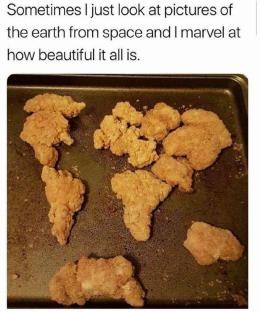

We can retrieve this image summary:

In [37]:
retriever.get_relevant_documents("Images / figures with playful and creative examples")[
    0
]

"LLaVA User Do you know who drew this painting? The painting depicts a woman, commonly believed to be Mona Lisa, the famous artwork by Leonardo da Vinci. It is a portrait painting that showcases the woman's enigmatic smile and has become one of the most famous and iconic art pieces in the world. The original work is displayed in the Louvre Museum in Paris, and it is known for its intricate details, use of oil paint, and the artist's innovative techniques that contributed to its enduring appeal and mystery. Start a new conversation, and the history is cleared. Do you know who drew this painting? The painting depicts a dog in a humorous situation, where it appears to be wearing a woman's dress and standing in front of a landscape. Although the artist of the painting is not explicitly identified, it could be a reference to the famous artist Da Vinci, known for his artistic works, including the Mona Lisa. The painting is likely a creative and comical take on the traditional portrait style,

## RAG

Run [RAG pipeline](https://python.langchain.com/docs/expression_language/cookbook/retrieval).

For `option 1` (above): 

* Simply pass retrieved text chunks to LLM, as usual.

For `option 2a` (above): 

* We would pass retrieved image and images to the multi-modal LLM.
* This should be possible soon, once [llama-cpp-python add multi-modal support](https://github.com/abetlen/llama-cpp-python/issues/813).

In [38]:
from langchain_core.runnables import RunnablePassthrough

# Prompt template
template = """Answer the question based only on the following context, which can include text and tables:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# Option 1: LLM
model = ChatOllama(model="llama2:13b-chat")
# Option 2: Multi-modal LLM
# model = LLaVA

# RAG pipeline
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [42]:
print(chain.invoke(
    "What is the performance of LLaVa across across multiple image domains / subjects?"
))

 Based on the provided text, there is no direct mention of the performance of LLaVA across multiple image domains or subjects. However, the text discusses the capabilities of LLaVA in understanding and responding to visual content, as well as its ability to recognize famous artwork and understand humor.

To assess the performance of LLaVA across multiple image domains or subjects, one could use a variety of metrics and evaluation methods, such as:

1. Accuracy: Measure the accuracy of LLaVA's responses to questions about visual content, such as identifying objects or describing scenes.
2. F1-score: Calculate the F1-score of LLaVA's responses to questions about visual content, which takes into account both precision and recall.
3. ROC-AUC: Evaluate the performance of LLaVA in recognizing famous artwork or other visual concepts using the Receiver Operating Characteristic (ROC) area under the curve (AUC) metric.
4. Human evaluation: Conduct human evaluations to assess the quality and rele

We can check the [trace](https://smith.langchain.com/public/ab90fb1c-5949-4fc6-a002-56a6056adc6b/r) to review retrieval.

In [43]:
print(chain.invoke(
    "Explain any images / figures in the paper with playful and creative examples."
))

The paper includes several images / figures that can be explained with playful and creative examples:

1. Figure 1: The first image is a screenshot of a conversation between two people, with one person asking, "What are some things that are important to consider when choosing a new laptop?" The other person is providing a list of factors to consider, such as the laptop's weight, processing power, and battery life. This image can be explained with a playful example of a person trying to choose a new superhero suit, with the list of factors to consider representing the various powers and abilities that the superhero might need.

2. Figure 5: The fifth image is a painting of a woman, commonly believed to be Mona Lisa, the famous artwork by Leonardo da Vinci. This image can be explained with a creative example of a person trying to paint a smile on their face, just like the enigmatic smile of the Mona Lisa.

3. Figure 6: The sixth image is an interesting emergent behavior of LLaVA, which r

We can check the [trace](https://smith.langchain.com/public/c6d3b7d5-0f40-4905-ab8f-3a2b77c39af4/r) to review retrieval.